In [ ]:
                  ########################################################################################################
                  #########                                 Start of Chapter 4                                   #########
                  ########################################################################################################


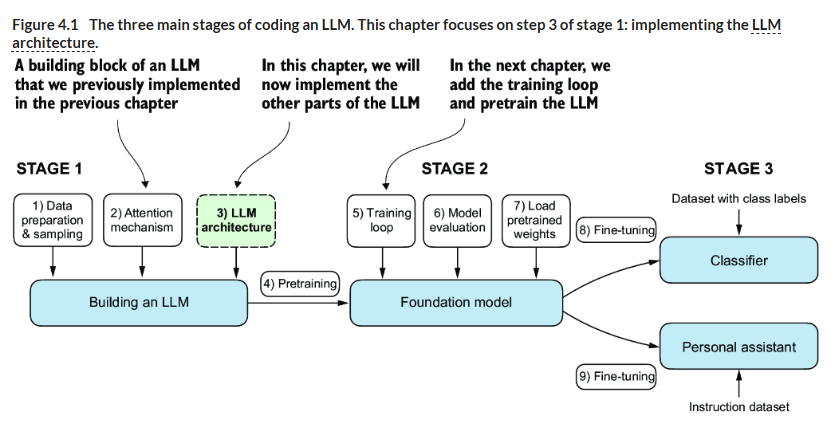

In [ ]:
'''
LLM's like gpt are meant for next token prediction
'''

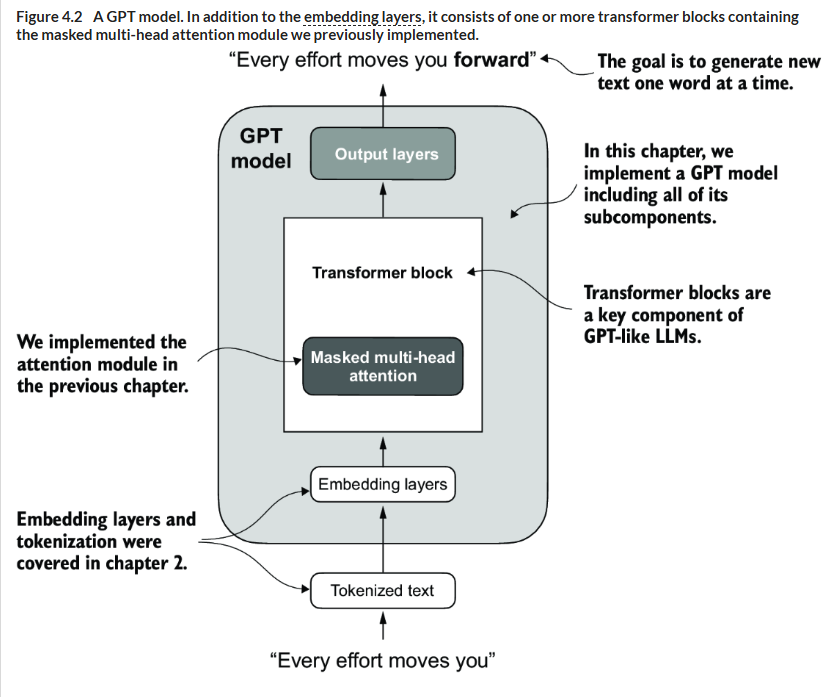

In [ ]:
'''
We've already implemented tokenisation and attention, now we will implement core structure of the gpt model including the transformer block.
'''

"\nWe've already implemented tokenisation and attention, now we will implement core structure of the gpt model including the transformer block.\n"

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [ ]:
'''
1. vocab_size = 50257 words as used in BPE tokenizer
2. context_length = 1024 max number of input tokens that the model can handle
3. emb_dim = 768 specifies the output embedding dimension for each token
4. n_heads = 12 number of attention heads
5. n_layers = 12 number of transformer blocks
6. qkv_bias = false -> specifies whether to include a bias vector in the Linear layers of the multi-head attention for query, key, and value computations. Will revisit this



We will now implement a GPT placeholder architecture (DummyGPTModel) as shown below. Will provide us with the overall big picture and what all components we still need to code.
'''

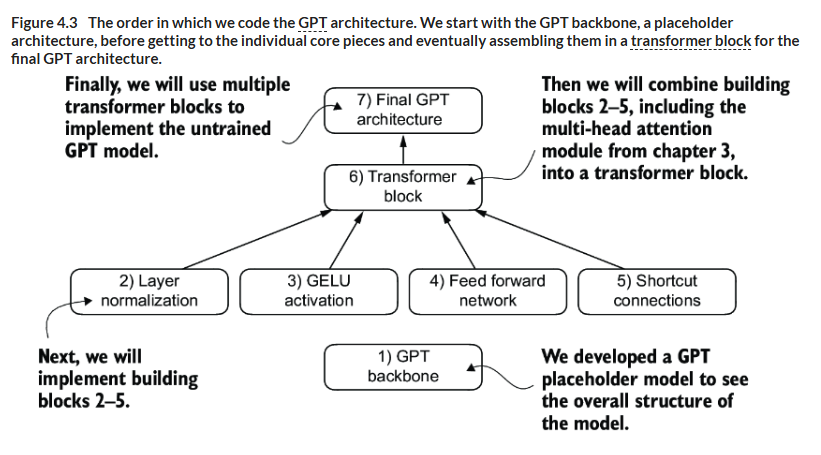

In [2]:
# Placeholder gpt model class

import torch
import torch.nn as nn

class DummyGptModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg)
        for _ in range(cfg["n_layers"])] # Placeholder for the transformer, we stack em'
    )
    self.final_norm = DummyLayerNorm(cfg["emb_dim"]) # Uses a placeholder for LayerNorm
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias = False # Projects the final token representations into logits for the vocabulary.
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx) # this is a lookup table
    pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device) # feed the range of numbers (0, seq_len-1)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits

class DummyTransformerBlock(nn.Module):

  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x


class DummyLayerNorm(nn.Module):

  def __init__(self, normalized_shape, eps = 1e-5):
    super().__init__()

  def forward(self, x):
    return x



In [ ]:
'''
The forward method in the Gpt class describes the flow of data in the gpt model, it first computes token and positional embeddings for the input, then it applies drop out to the mebdding followed by
passing it through a series of transformer blocks, applies normalization finally producing logits using a linear layer for next word prediction
'''

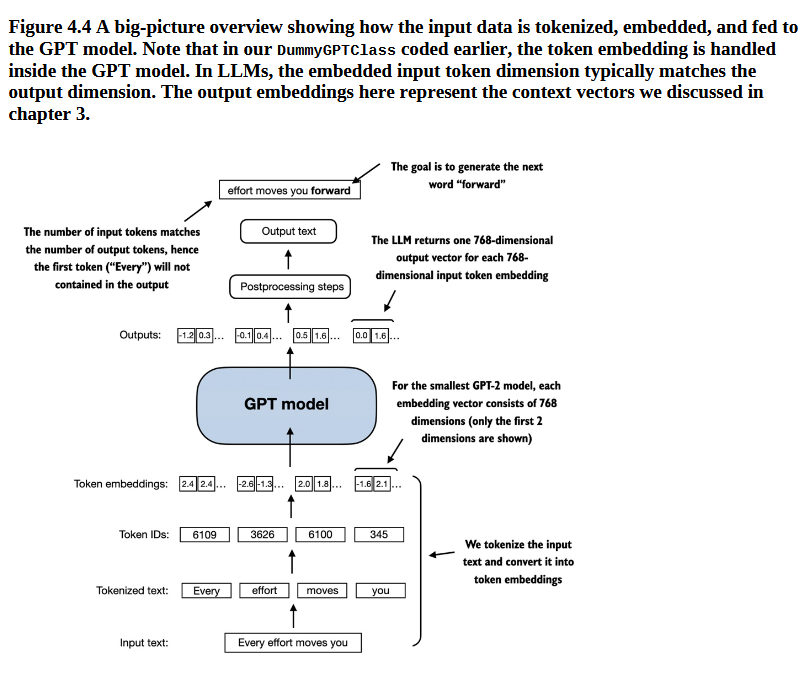

In [3]:
!pip install tiktoken

In [4]:
'''
To implement 4.4 we will use tiktoken tokenizer to tokenize two input sentences
'''

import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
#print(batch)
batch = torch.stack(batch, dim = 0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
# Initialize the 124M gpt dummy model instance and feed it tokenized batch

torch.manual_seed(123)
model = DummyGptModel(GPT_CONFIG_124M)
logits = model(batch)
print("output shape: ", logits.shape)
print(logits)

output shape:  torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


In [6]:
'''
the embedding has 50257 dims since each dimension refers to a unique token in the vocab, at the end we'll code out post processing that will help decode it into words
'''

"\nthe embedding has 50257 dims since each dimension refers to a unique token in the vocab, at the end we'll code out post processing that will help decode it into words\n"

In [ ]:
# We will now code the DummyLayerNorm class, we implement this to deal with the problem of vanishing and exploding gradients
# the main idea of layernorm is to adjust the activations such that their mean is 0 and variance = 1, speeds up convergence
# applied before and after multi-head attention module and before final layer

# Refer to the diag. below

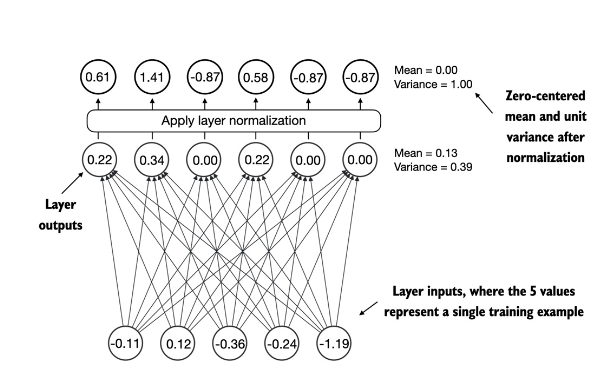

In [6]:
# Example of layer norm

# before layer norm
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
activations = layer(batch_example)
print(activations)

mean = activations.mean(dim=-1, keepdim=True) # keepdim = true makes sure that the return vec has same shape as input tensor otherwise output would have been of shape (2, )
var = activations.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


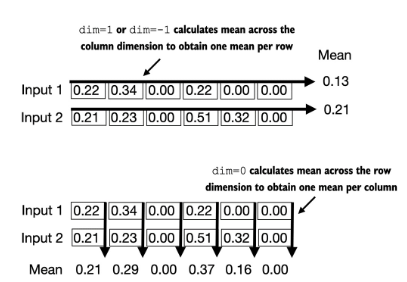

In [7]:
# after layer norm
out_norm = (activations - mean)/torch.sqrt(var)
mean = out_norm.mean(dim = -1, keepdim = True)
var = out_norm.var(dim = -1, keepdim = True)

print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
# Layer norm class

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    norm_x = (x - x.mean(dim = -1, keepdim=True))/torch.sqrt(x.var(dim = -1, keepdim = True, unbiased = False) + self.eps)
    return self.scale*norm_x + self.shift # scale and shift are two trainable params, that LLM automatically adjusts if doing so improves model performance.

In [10]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
'''
Biased Variance ->  In the variance calculation we've set the unbiased parameter to be False. In the variance calc, we generally divide by n in var formula. bessel's correction divides by n-1 to get
unbiased estimate, we stick to n in accordance to Gpt -2 implemented in tensorflow which by default divides by n


P.S. We do layer normalization instead of batch normalization in case of LLMs since layer norm offers more flexibility, batch dimensions can vary by a lot depending on hardware, model arch, etc.

Our Progress till now
'''

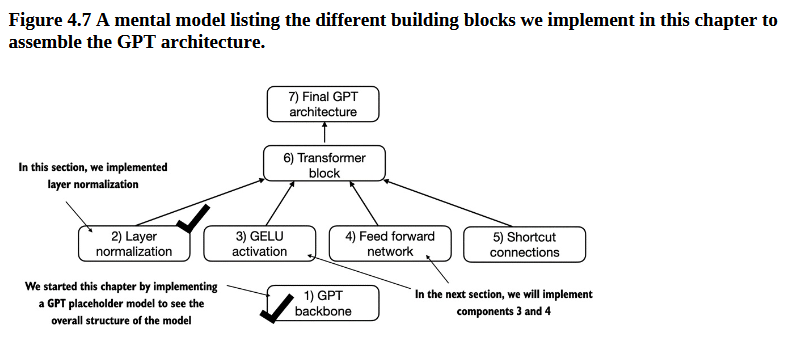

In [11]:
# Implementing Feed forward Neural network using '''GELU activations'''

'''
two activation functions that are generally used in LLMs apart from traditional ReLU - GELU(Gaussian Error Linear Unit) and SwiGLU(Sigmoid-Weighted Linear Unit).
'''

'''
1. GELU(x) = X*phi(x) -> phi(x) = cdf of standard gaussian

    GELU(x) ≈ 0.5 ⋅ x ⋅ (1 + tanh[√((2/π)) ⋅ (x + 0.044715 ⋅ x^3])
'''

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    gelu = 0.5*x*(1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x + 0.044715*x**3)))
    return gelu

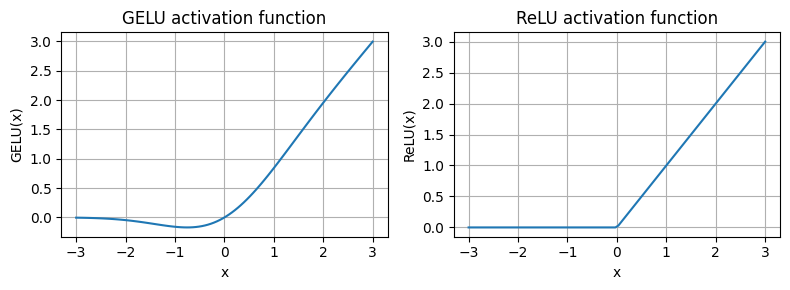

In [12]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100) #A
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
'''
The smoothness of GELU, as shown in Figure, can lead to better
optimization properties during training, as it allows for more nuanced
adjustments to the model's parameters. In contrast, ReLU has a sharp corner
at zero, which can sometimes make optimization harder, especially in
networks that are very deep or have complex architectures. Moreover, unlike
RELU, which outputs zero for any negative input, GELU allows for a small,
non-zero output for negative values. This characteristic means that during the
training process, neurons that receive negative input can still contribute to the
learning process, albeit to a lesser extent than positive inputs.
'''

In [13]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

In [14]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [ ]:
'''
The FeedForward module enhances the model's learning and generalization by temporarily expanding the embedding dimension to a higher-dimensional space through a linear layer,
applying a GELU activation for non-linearity, and then contracting it back to the original dimension. This design enables the model to explore richer representations.
'''

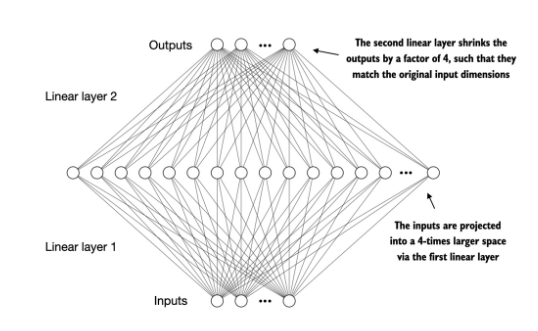

In [ ]:
'''
Our progress after all these steps
'''

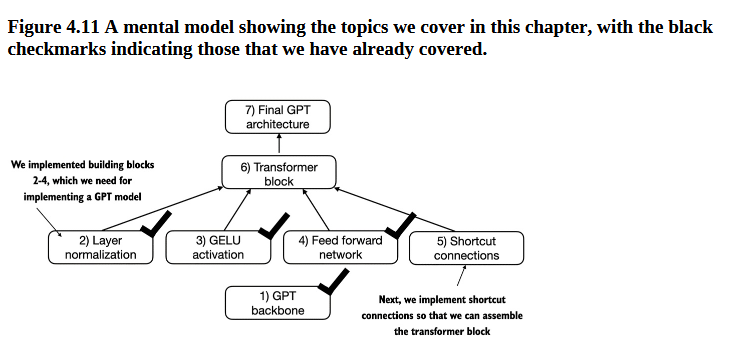

In [ ]:
'''
Now we add shortcut connections between different layers of neural network for improving performance in deep neural network

skip or residual connections is a concept that comes from computer vision to solve vanishing gradient problem. skip connections create an alternative path for
gradient to flow back bypassing layers.

Illustration
'''

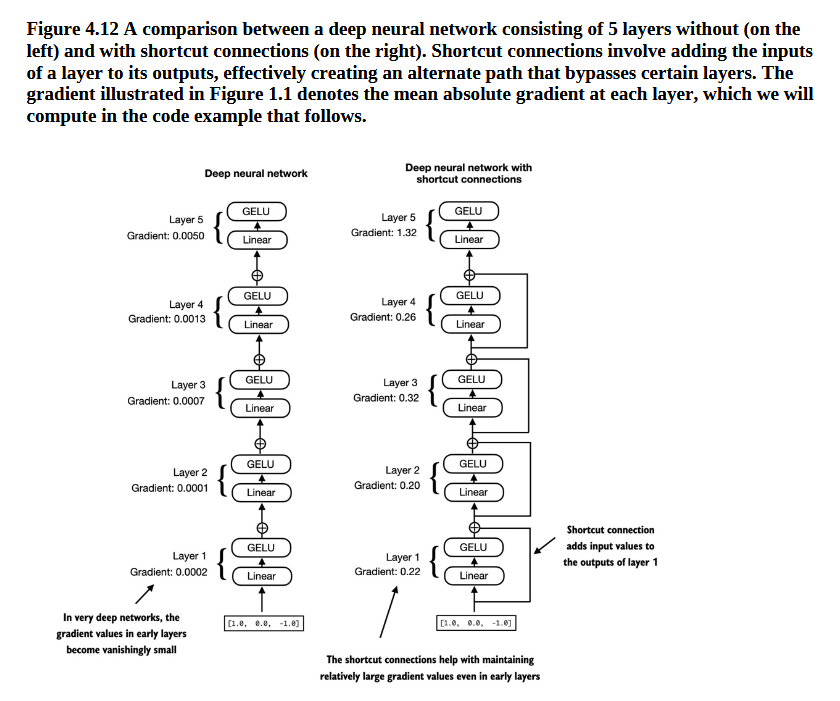

In [15]:
# coding out the deep neural network class with skip connections

class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    # reason for using modulelist is that we want to apply skip connections after one block of Linear layer and GELU, if we use nn.Sequential() we apply it after every operation
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                      GELU())
        ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x

In [16]:
# Example

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut = False)
output = model_without_shortcut(sample_input)
print(output)

tensor([[0.0610]], grad_fn=<MulBackward0>)


In [17]:
'''
Now we implement a function that computes gradients in model's backward pass
'''

def print_gradient(model, x):
  # forward pass
  output = model(x)
  target = torch.tensor([[0.]])

  # loss calculation
  loss = nn.MSELoss()
  loss = loss(output, target)

  # backward pass
  loss.backward() # automatically computes gradients for all the layers

  for name, param in model.named_parameters():
    if 'weight' in name:
      # print gradient
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}") # we are basically printing the mean gradient of each layer to compare, that is the whole point of this function

In [18]:
print_gradient(model_without_shortcut, sample_input) # observe how the model gradients get way smaller with proceeding layers

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [19]:
# we will now implement skip connections, observe how the gradients drop as fast as the prev case, problem of vanishing gradients solved

torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut = True)
print_gradient(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [ ]:
'''
Overall skip connections solve the problem of vanishing gradients in very deep neural network which we frequently encounter in LLMs, so to solve this we make use of skip connections.
'''

In [ ]:
'''
We finally implement the transformer block which is repeated a dozen times in the 124M GPT-2 architecture. It combines all the prev concepts: multi-head attention,
layer normalization, dropout, feed forward layers, and GELU activations
'''

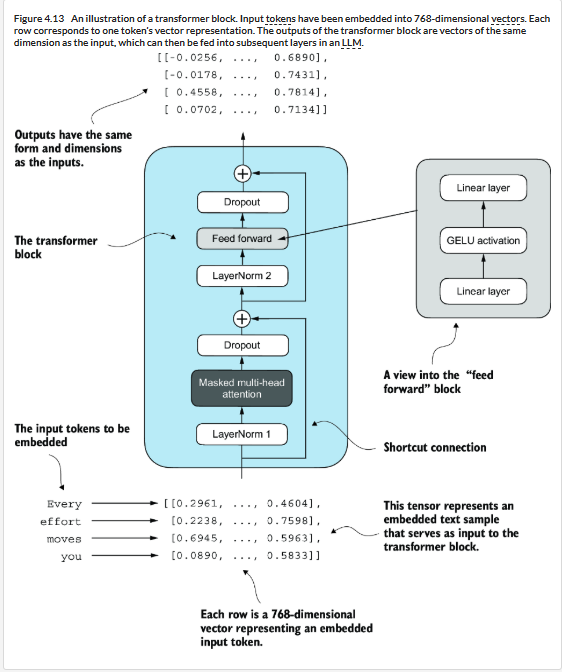

In [ ]:
'''
The input and the output after passing through the transformer the dimension of the input is preserved.

The idea is that the self-attention mechanism in the multi-head attention
block identifies and analyzes relationships between elements in the input
sequence. In contrast, the feed forward network modifies the data
individually at each position. This combination not only enables a more
nuanced understanding and processing of the input but also enhances the
model's overall capacity for handling complex data patterns.
'''

In [20]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )



    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(
            b, num_tokens, self.num_heads, self.head_dim
        )

        keys = keys.transpose(1, 2) #transposing and switching along dims 1 and 2
        queries = queries.transpose(1, 2) #transposing and switching along dims 1 and 2
        values = values.transpose(1, 2) #transposing and switching along dims 1 and 2

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)
        return context_vec

In [21]:
'''
We apply normalization before two blocks two prevent overfitting, older architectures applied after respective blocks but this led to worse training dynamics.
'''

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_resid = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    # A
    shortcut = x # the input
    x = self.norm1(x) # normalising the input before applying attention
    x = self.att(x) # attention
    x = self.drop_resid(x) # dropout
    x = x + shortcut # Adding back the original input, shortcut connection

    # B
    # passing the input through a linear network, helps it learn complex representation by transforming embeddings in a higher-dimensional space, allowing it to capture richer feature interactions.
    shortcut = x
    x = self.norm2(x) # applying norm once more
    x = self.ff(x)
    x = self.drop_resid(x)
    x = x + shortcut # C

    return x

In [22]:
# Instantiating a transformer block

torch.manual_seed(123)

x = torch.rand(2, 4, 768)
transformer_block = TransformerBlock(GPT_CONFIG_124M)
output = transformer_block(x)

print("Input shape: ", x.shape)
print("output shape: ", output.shape)

Input shape:  torch.Size([2, 4, 768])
output shape:  torch.Size([2, 4, 768])


In [24]:
'''
The transformer's architecture preserves the shape of the input throughout its blocks, ensuring a one-to-one correspondence between input and output vectors.
While the sequence's dimensions remain unchanged, each output vector is re-encoded to incorporate contextual information from the entire input sequence,
making it effective for sequence-to-sequence tasks.
'''

"\nThe transformer's architecture preserves the shape of the input throughout its blocks, ensuring a one-to-one correspondence between input and output vectors.\nWhile the sequence's dimensions remain unchanged, each output vector is re-encoded to incorporate contextual information from the entire input sequence, \nmaking it effective for sequence-to-sequence tasks.\n"

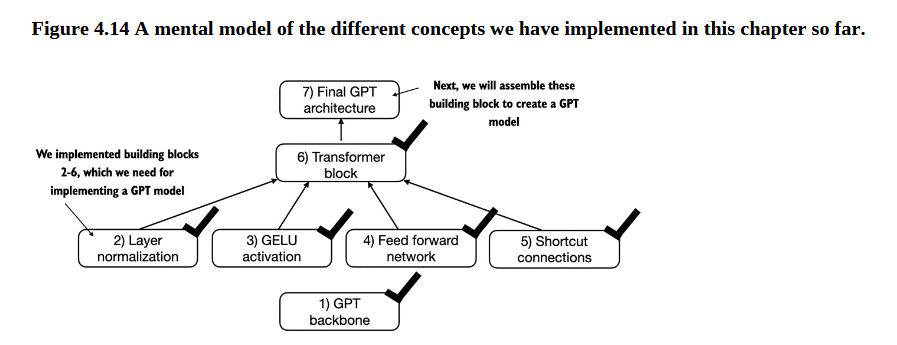

In [ ]:
# Coding the gpt model

'''
We started this chapter with a big-picture overview of a GPT architecture that
we called DummyGPTModel. In this DummyGPTModel code implementation, we
showed the input and outputs to the GPT model, but its building blocks
remained a black box using a DummyTransformerBlock and DummyLayerNorm
class as placeholders.
In this section, we are now replacing the DummyTransformerBlock and
DummyLayerNorm placeholders with the real TransformerBlock and
LayerNorm classes we coded later in this chapter to assemble a fully working
version of the original 124 million parameter version of GPT-2. In chapter 5,
we will pretrain a GPT-2 model, and in chapter 6, we will load in the
pretrained weights from OpenAI.
'''

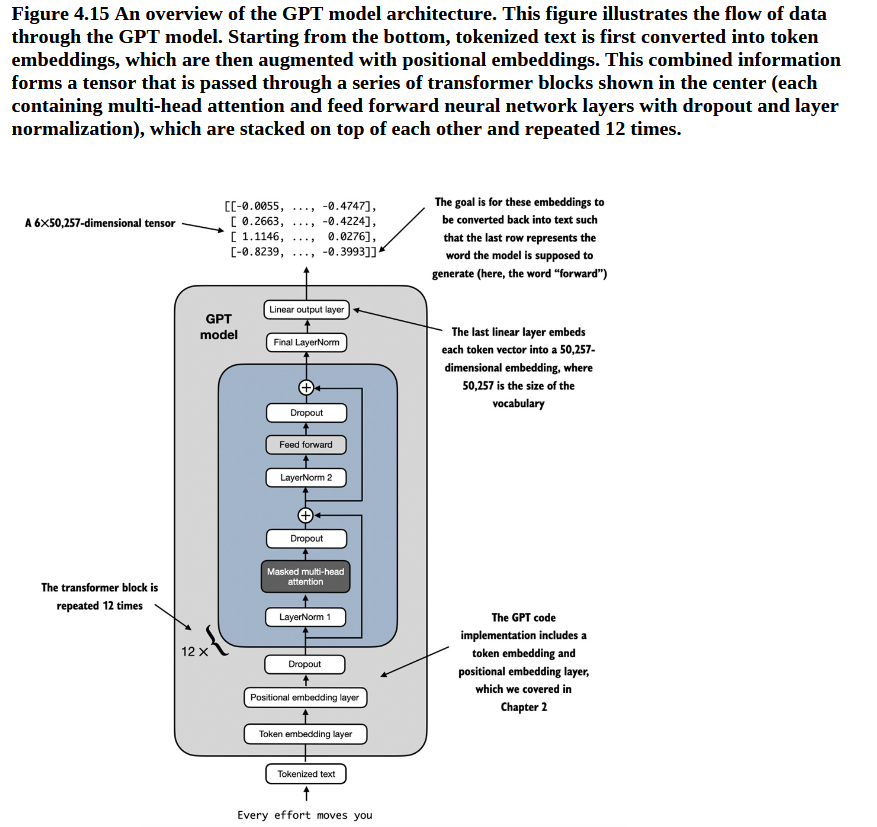

In [23]:
# GPT Model class - Final

class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])
                                    ])

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_emb = self.tok_emb(in_idx)
    pos_emb = self.pos_emb(
        torch.arange(seq_len, device = in_idx.device)
    )

    x = tok_emb + pos_emb
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)

    logits = self.out_head(x)
    return logits

In [24]:
# Initializing a instance

torch.manual_seed(123)
gpt_model = GPTModel(GPT_CONFIG_124M)

out = gpt_model(batch)

print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [25]:
# number of params in the model ~ 163 M

total_params = sum(p.numel() for p in gpt_model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [ ]:
'''
There is a discrepancy in the number of parameters, it is around 163 mill, that is due to GPT 2 reusing weights from the token embedding layer in its output layer.
Lets see the shape of token embedding layer and linear output layer
'''

In [26]:
print("Token embedding layer shape:", gpt_model.tok_emb.weight.shape)
print("Output layer shape:", gpt_model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [27]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in gpt_model.out_head.parameters())
)
print(f"Number of trainable parameters "f"considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [ ]:
'''
weight tying reduces computational complexity of the model and memory footprint of the model. We will revisit which method is better later.
'''

In [28]:
# memory requirement for 163M gpt model

total_memory_bytes = total_params*4 # A
total_memory_mbs = total_memory_bytes/(1024*1024) # B
print(f"Total size of the model: {total_memory_mbs:.2f} MB")

Total size of the model: 621.83 MB


In [ ]:
'''
The output has shape [batch_size, num_tokens, vocab_size], now we need to write code to convert this into text.
'''

In [29]:
# Just seeing number of params in gpt-2 medium and gpt-2 large

GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

GPT_2_MEDIUM = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 1024,          # Embedding dimension
    "n_heads": 16,           # Number of attention heads
    "n_layers": 24,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

GPT_2_LARGE = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 1280,          # Embedding dimension
    "n_heads": 20,           # Number of attention heads
    "n_layers": 36,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

GPT_2_XLARGE = {   # This is the main one
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 1600,          # Embedding dimension
    "n_heads": 25,           # Number of attention heads
    "n_layers": 48,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

#gpt_model_medium = GPTModel(GPT_2_XLARGE) ~ 355 million
#gpt_model_large = GPTModel(GPT_2_LARGE) ~ 774 million
#gpt_model_xlarge = GPTModel(GPT_2_XLARGE) ~ 1.5 billion

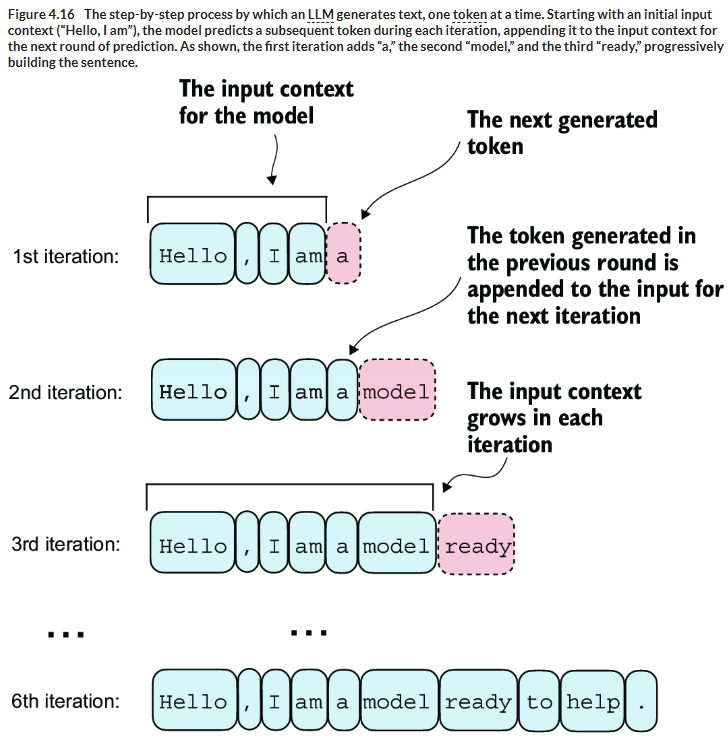

In [ ]:
# Generating text

'''
The way gpt model goes from output tensor to text involves several steps, these steps include decoding the output tensors and selecting next token based on probability distribution
and then converting these tokens into human readable form.
'''

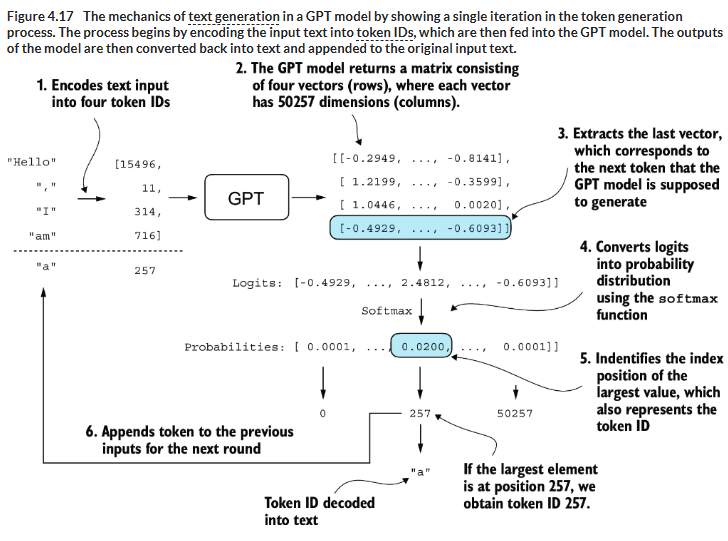

In [30]:
def generate_simple_text(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim = -1)
    idx_next = torch.argmax(probas, dim = -1, keepdim = True)
    idx = torch.cat((idx, idx_next), dim = -1)

  return idx

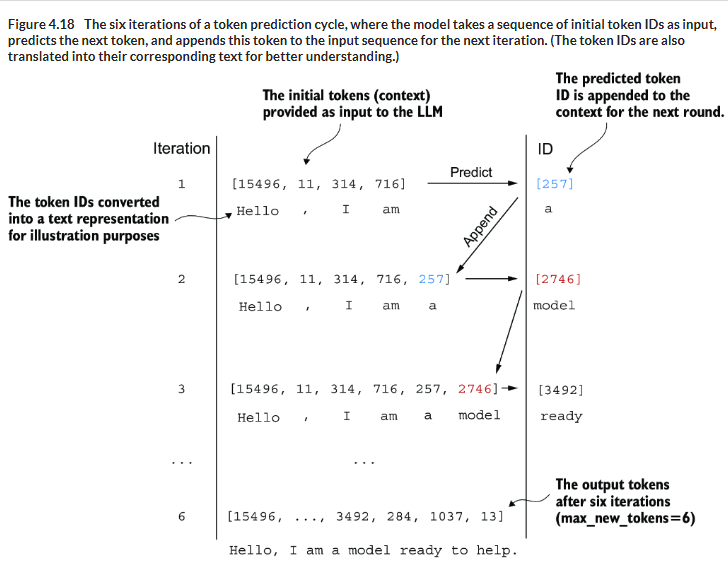

In [31]:
# Text generation example

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encode: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encode:  [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [32]:
# now we will put the model into eval only mode, which disables components like dropout and stuff and use generate_text_simple on the encoded input tensor

gpt_model.eval()
out = generate_simple_text(
    model = gpt_model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output: ", out)
print("Output length:", len(out[0]))

Output:  tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [33]:
# decoding the output

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


In [ ]:
'''
The model output is gibberish since we have not trained it yet, we will cover that later lol
'''

In [ ]:
### Summary

'''
1. Layer normalization stabilizes training by ensuring that each layer's
outputs have a consistent mean and variance.

2. Shortcut connections are connections that skip one or more layers by
feeding the output of one layer directly to a deeper layer, which helps
mitigate the vanishing gradient problem when training deep neural
networks, such as LLMs.

3. Transformer blocks are a core structural component of GPT models,
combining masked multi-head attention modules with fully connected
feed-forward networks that use the GELU activation function.

4. GPT models are LLMs with many repeated transformer blocks that have
millions to billions of parameters.

5. GPT models come in various sizes, for example, 124, 345, 762, and
1542 million parameters, which we can implement with the same
GPTModel Python class.

6. The text generation capability of a GPT-like LLM involves decoding
output tensors into human-readable text by sequentially predicting one
token at a time based on a given input context.

7. Without training, a GPT model generates incoherent text, which
underscores the importance of model training for coherent text
generation, which is the topic of subsequent chapters.
'''

In [ ]:
                  ########################################################################################################
                  ##########                                 End of Chapter 4                                   ##########
                  ########################################################################################################